# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.1016],
         [0.5184]]),
 tensor([[1.0000e+00, 1.0159e-01, 5.1607e-03, 1.7476e-04, 4.4387e-06, 9.0189e-08,
          1.5271e-09, 2.2164e-11, 2.8146e-13, 3.1772e-15, 3.2278e-17, 2.9812e-19,
          2.5239e-21, 1.9724e-23, 1.4313e-25, 9.6941e-28, 6.1554e-30, 3.6785e-32,
          2.0762e-34, 1.1102e-36],
         [1.0000e+00, 5.1839e-01, 1.3437e-01, 2.3218e-02, 3.0091e-03, 3.1198e-04,
          2.6954e-05, 1.9962e-06, 1.2935e-07, 7.4504e-09, 3.8623e-10, 1.8202e-11,
          7.8630e-13, 3.1355e-14, 1.1610e-15, 4.0124e-17, 1.3000e-18, 3.9642e-20,
          1.1417e-21, 3.1150e-23]]),
 tensor([5.0313, 5.4552]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 4.9957767  1.2065831 -3.403074   5.5830116]]


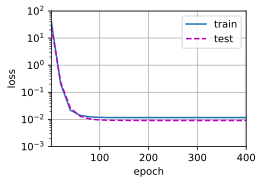

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.663051 5.801604]]


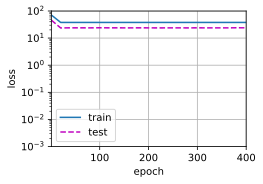

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9981499e+00  1.2585148e+00 -3.4176238e+00  5.3090148e+00
  -4.0034361e-02  8.3421910e-01  6.5890819e-01 -3.6292377e-01
  -6.8464115e-02 -2.1371493e-01  2.1373889e-01  5.8054410e-02
  -4.6973106e-02  4.7570220e-03 -5.3894434e-02 -2.1651585e-01
  -9.2220679e-02 -1.0334523e-02 -1.8232554e-01 -1.9509374e-01]]


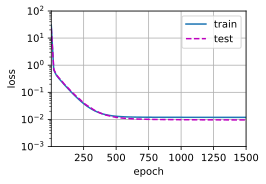

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)